In [1]:
%matplotlib inline
import chainer
import matplotlib.pyplot as plt
import net_2
import numpy as np
import os
import chainer.functions as F
from train_vae_with_specified_label import *

In [2]:
# set paths and paramters
out_dir_path = './result_with_specified_label_1000'
log_path = os.path.join(out_dir_path, 'log')
model_name = 'model_1000.npz'
dimz = 100

In [3]:
# load a model
model = net_2.VAE(784, dimz, 500, F.softplus) 
chainer.serializers.load_npz(os.path.join(out_dir_path, model_name), model, strict=True)
model.to_cpu()

In [4]:
# load dataset
src_train, src_test = chainer.datasets.get_mnist(withlabel=True) 

In [5]:
# extract specified labels
specified_label = 5
train = extract_specified_labels(src_train, specified_label)
test = extract_specified_labels(src_test, specified_label)

In [6]:
def save_images(x, filename):
    fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi.reshape(28, 28))
    fig.savefig(filename)

In [7]:
# encode and decode training dataset
train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]  
x = chainer.Variable(np.asarray(train[train_ind])) 
with chainer.using_config('train', False), chainer.no_backprop_mode(): 
    x1 = model(x) 

train


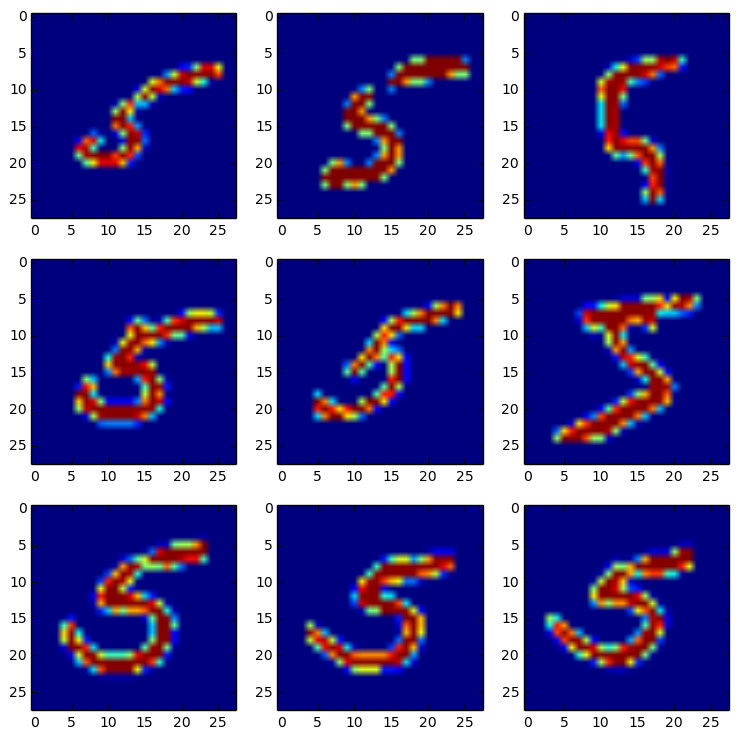

In [8]:
print('train')
save_images(x.data, os.path.join(out_dir_path, 'train')) 

train_reconstructed


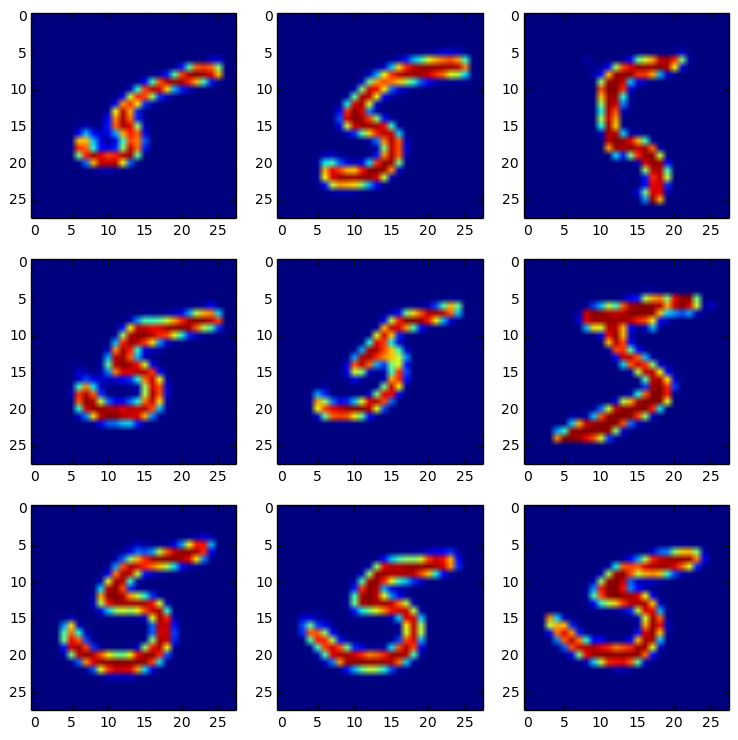

In [9]:
print('train_reconstructed')
save_images(x1.data, os.path.join(out_dir_path, 'train_reconstructed'))  

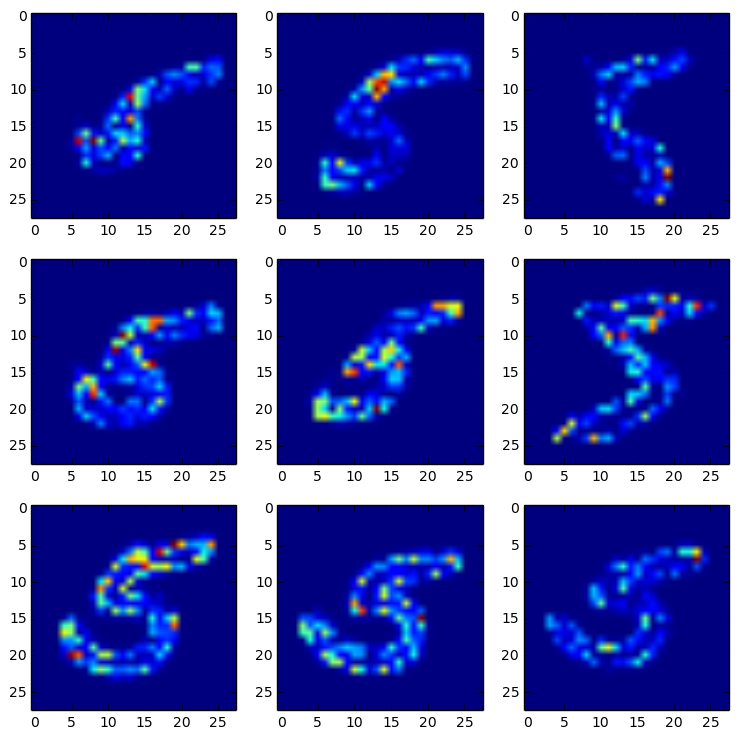

In [10]:
# 差をとる。
dx = np.abs(x.data - x1.data)
save_images(dx, os.path.join(out_dir_path, 'train_diff')) 

In [11]:
# # encode and decode training dataset
test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
x = chainer.Variable(np.asarray(test[test_ind]))
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)

test


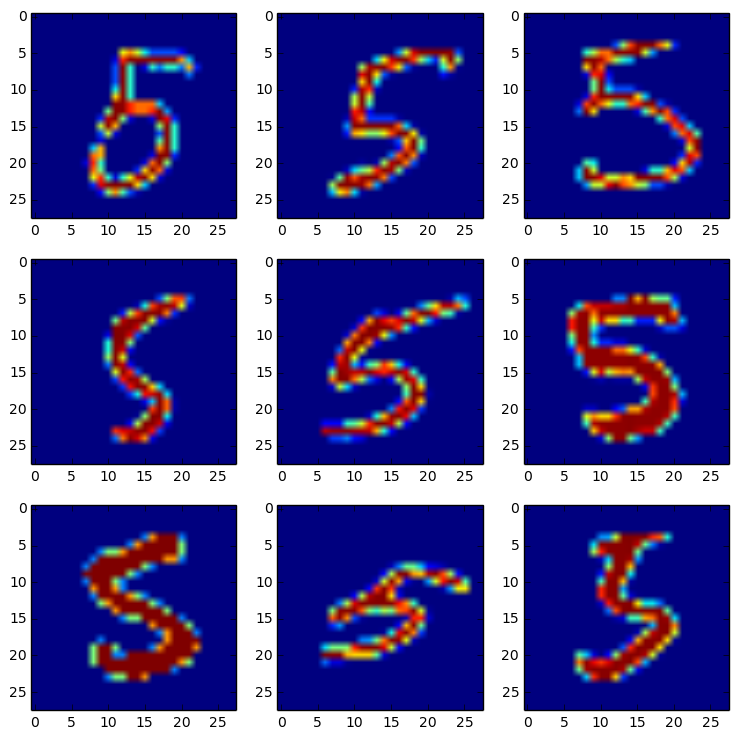

In [12]:
print('test')    
save_images(x.data, os.path.join(out_dir_path, 'test'))

test reconstructed


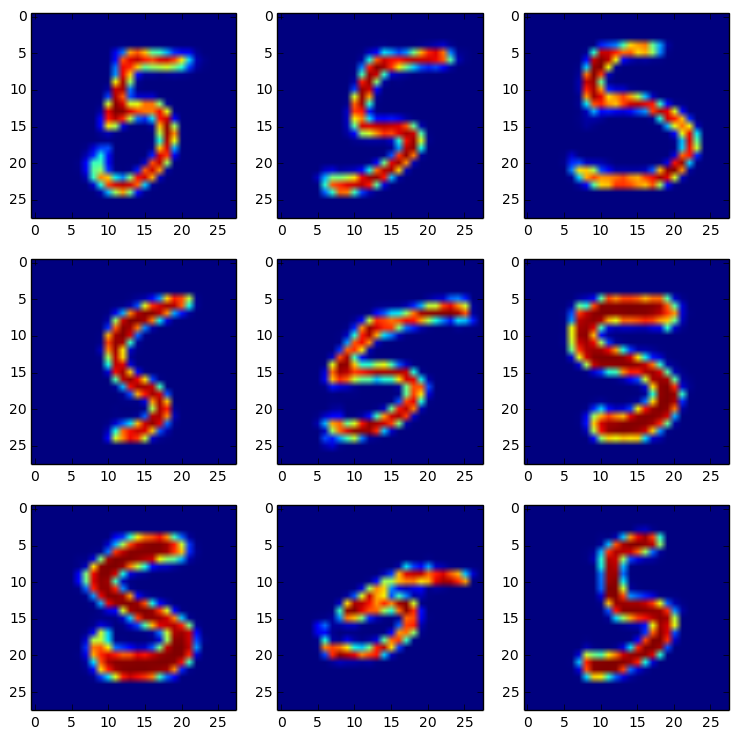

In [13]:
print('test reconstructed')
save_images(x1.data, os.path.join(out_dir_path, 'test_reconstructed'))

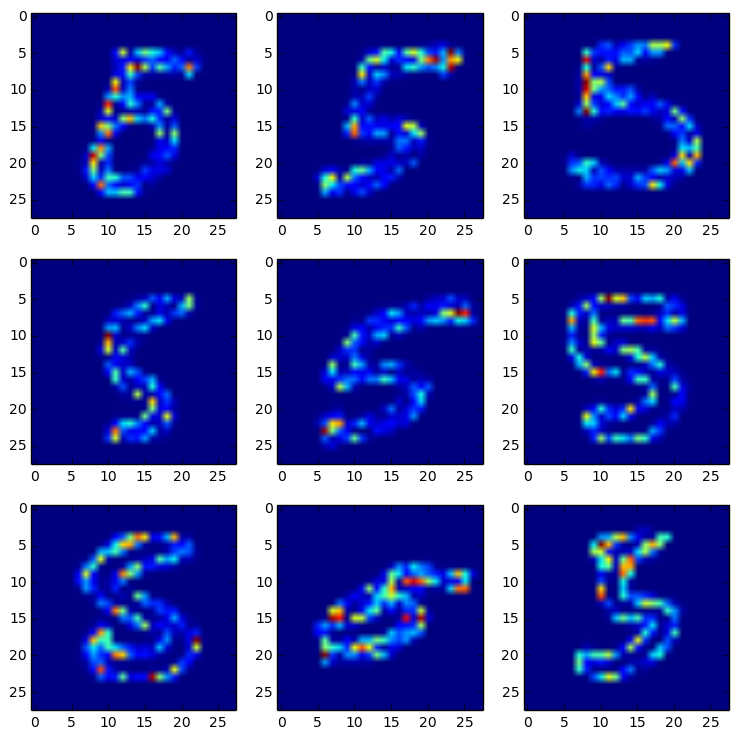

In [14]:
# 差をとる。
dx = np.abs(x.data - x1.data)
save_images(dx, os.path.join(out_dir_path, 'test_diff')) 

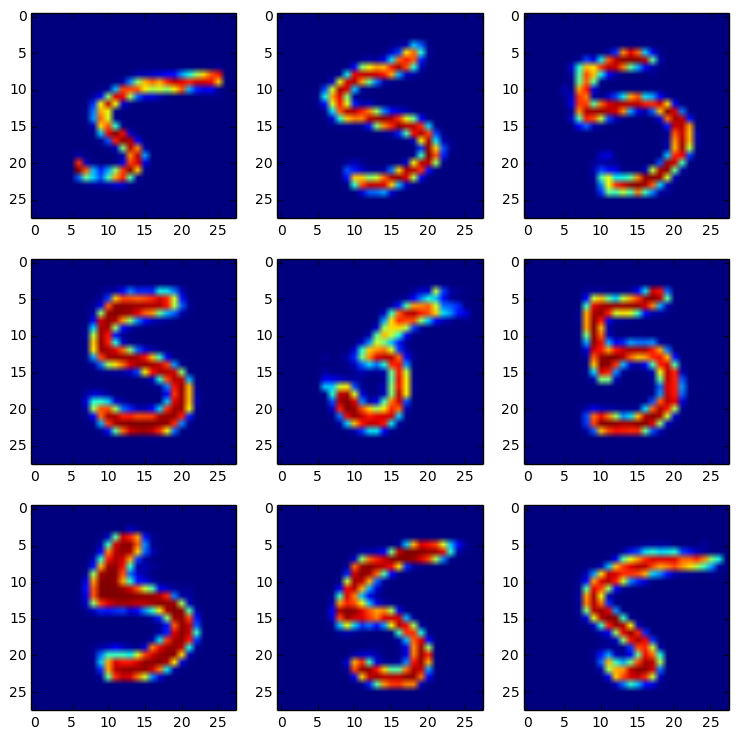

In [15]:
# draw images from randomly sampled z
np.random.seed(1234)
z = chainer.Variable(
    np.random.normal(0, 1, (9, dimz)).astype(np.float32))
x = model.decode(z)
save_images(x.data, os.path.join(out_dir_path, 'sampled'))

In [16]:
def load_loss(path):
    return [float(line) for line in open(path)]

import re
def loss_generator(path, s):
    s = re.compile(r'"{}": (-?[0-9]+.[0-9]+),?'.format(s))
    for line in open(path):
        m = s.findall(line)
        if m:
            yield float(m[0])

In [17]:
main_loss = list(loss_generator(log_path, 'main/loss'))
validation_main_loss = list(loss_generator(log_path, 'validation/main/loss'))
main_mu = list(loss_generator(log_path, 'main/mu'))
validation_main_mu = list(loss_generator(log_path, 'validation/main/mu'))
main_sigma = list(loss_generator(log_path, 'main/sigma'))
validation_main_sigma = list(loss_generator(log_path, 'validation/main/sigma'))

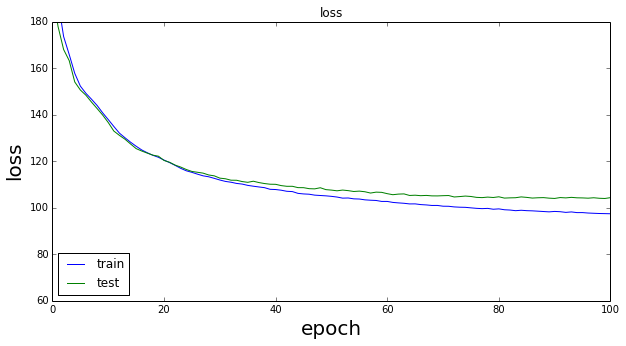

In [18]:
plt.figure(figsize=(10, 5))
plt.title('loss')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.xlim(0, 100)
plt.ylim(60, 180)
plt.plot(main_loss, label='train')
plt.plot(validation_main_loss, label='test')
plt.legend(loc='best')
plt.show()

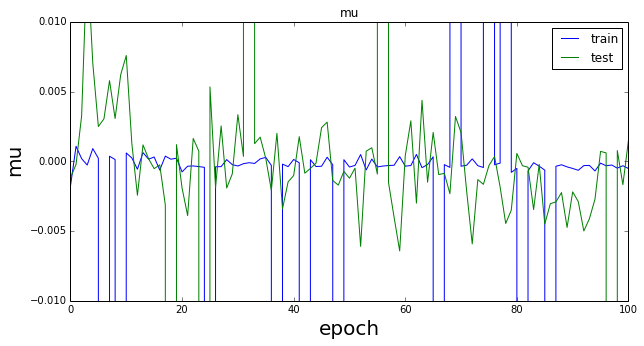

In [19]:
plt.figure(figsize=(10, 5))
plt.title('mu')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('mu', fontsize=20)
plt.xlim(0, 100)
plt.ylim(-0.01, 0.01)
plt.plot(main_mu, label='train')
plt.plot(validation_main_mu, label='test')
plt.legend(loc='best')
plt.show()

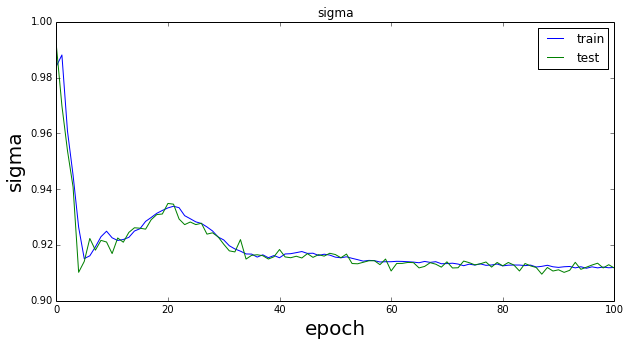

In [20]:
plt.figure(figsize=(10, 5))
plt.title('sigma')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('sigma', fontsize=20)
plt.xlim(0, 100)
# plt.ylim(8, 22)
plt.plot(main_sigma, label='train')
plt.plot(validation_main_sigma, label='test')
plt.legend(loc='best')
plt.show()

In [21]:
def decode(dataset):
    ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]  
    x = chainer.Variable(np.asarray(dataset[ind])) 
    with chainer.using_config('train', False), chainer.no_backprop_mode(): 
        mu, ln_var = model.encode(x) 
        average_mu = np.mean(mu.data)
        sigma = np.exp(ln_var.data/2)
        average_sigma = np.mean(sigma)
        return average_mu, average_sigma

In [22]:
mu, sigma = decode(train)
print('mu(0): {}'.format(mu))
print('sigma(1): {}'.format(sigma))

mu(0): -0.022784817963838577
sigma(1): 0.9094710946083069


In [23]:
mu, sigma = decode(test)
print('mu(0): {}'.format(mu))
print('sigma(1): {}'.format(sigma))

mu(0): 0.004014012403786182
sigma(1): 0.907390832901001


# 画像の符号化

In [24]:
# 100個取り出す。
five_number = 1000
fives = train[:five_number]
fives.shape

(1000, 784)

In [25]:
# 符号化する。
xs = chainer.Variable(fives) 
with chainer.using_config('train', False), chainer.no_backprop_mode(): 
    five_mus, five_ln_vars = model.encode(xs) 

In [26]:
net_2.calculate_means(five_mus, five_ln_vars)

(-0.0042686644, 0.90740508)

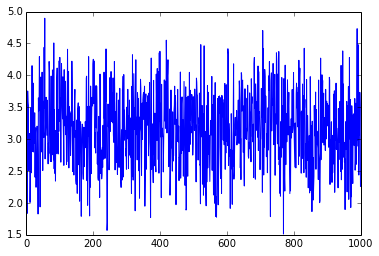

In [27]:
five_mus.shape
r = np.linalg.norm(five_mus.data, axis=1)
plt.plot(r)

In [28]:
anomaly_label = 1
ones = extract_specified_labels(src_train, anomaly_label)[:100]
ones.shape

(100, 784)

In [29]:
anomaly_label = 3
threes = extract_specified_labels(src_train, anomaly_label)[:100]
threes.shape

(100, 784)

In [30]:
# 符号化する。
xs = chainer.Variable(ones) 
with chainer.using_config('train', False), chainer.no_backprop_mode(): 
    one_mus, one_ln_vars = model.encode(xs) 

In [31]:
net_2.calculate_means(one_mus, one_ln_vars)

(-0.0013998471, 0.9078756)

In [32]:
# 符号化する。
xs = chainer.Variable(threes) 
with chainer.using_config('train', False), chainer.no_backprop_mode(): 
    three_mus, three_ln_vars = model.encode(xs) 

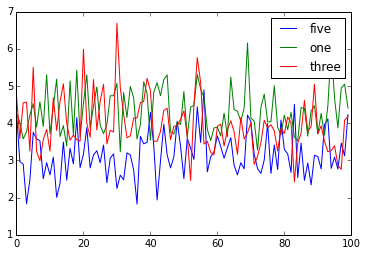

In [33]:
t = np.linalg.norm(five_mus.data, axis=1)
r = np.linalg.norm(one_mus.data, axis=1)
s = np.linalg.norm(three_mus.data, axis=1)
plt.plot(t[:100], label='five')
plt.plot(r, label='one')
plt.plot(s, label='three')
plt.legend(loc='best')
plt.show()

In [34]:
net_2.calculate_means(three_mus, three_ln_vars)

(0.047970504, 0.90521407)

In [35]:
print(five_mus.data.shape)
print(one_mus.data.shape)
print(three_mus.data.shape)

(1000, 100)
(100, 100)
(100, 100)


In [36]:
dataset = np.concatenate([five_mus.data, one_mus.data, three_mus.data], axis=0)
print(dataset.shape)

(1200, 100)


In [37]:
from sklearn.manifold import TSNE

In [38]:
# 次元を圧縮する。
reduced_dataset = TSNE(n_components=2, random_state=0).fit_transform(dataset)

In [39]:
reduced_dataset.shape

(1200, 2)

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


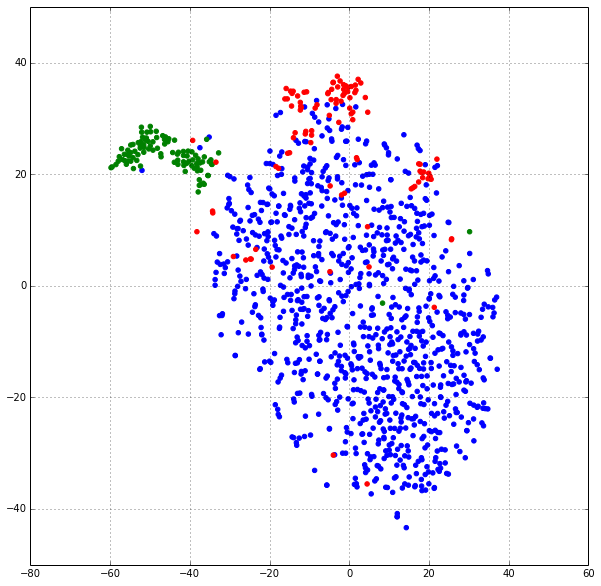

In [40]:
plt.figure(figsize=(10, 10))
plt.scatter(reduced_dataset[:five_number, 0], reduced_dataset[:five_number, 1], c='blue', edgecolors='blue', marker='o')
plt.scatter(reduced_dataset[five_number:five_number+100, 0], reduced_dataset[five_number:five_number+100, 1], c='green', edgecolors='green', marker='o')
plt.scatter(reduced_dataset[five_number+100:, 0], reduced_dataset[five_number+100:, 1], c='red', edgecolors='red', marker='o')

# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.grid(True)
plt.show()

# 画像の符号化・復号化

In [41]:
anomaly_label = 3
ones = extract_specified_labels(src_train, anomaly_label)[:9]
ones.shape

(9, 784)

In [42]:
x = chainer.Variable(ones)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)

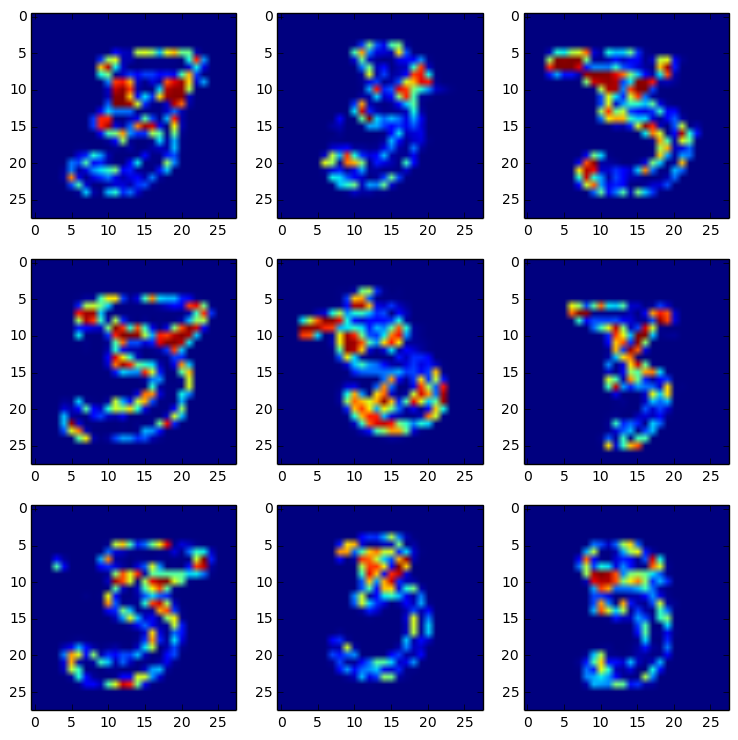

In [43]:
# 差をとる。
dx = np.abs(x.data - x1.data)
save_images(dx, os.path.join(out_dir_path, 'one_diff')) 